In [51]:
import os
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch
import matplotlib.pyplot as plt
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import torch.nn.functional as F
import torch.nn as nn
import torch.nn.functional as F

In [52]:
def get_image_transform():
    return transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor()
    ])

In [53]:
def prepare_image_pairs(original_folder, compressed_folders):
    """
    Prepares a list of image pairs with paths to original and corresponding compressed images.

    Args:
    original_folder (str): Directory containing original images.
    compressed_folders (list): List of directories containing compressed images at different quality levels.

    Returns:
    list: A list of tuples, each containing paths to an original image and a corresponding compressed image.
    """
    image_pairs = []
    
    original_images = [f for f in os.listdir(original_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
    
    for filename in original_images:
        original_image_path = os.path.join(original_folder, filename)
        for compressed_folder in compressed_folders:
            compressed_image_path = os.path.join(compressed_folder, filename)
            if os.path.exists(compressed_image_path):
                image_pairs.append((original_image_path, compressed_image_path))
    
    return image_pairs

In [54]:
def load_and_transform_images(image_pairs, transform=None):
    """
    Loads and transforms original and compressed images.

    Args:
    image_pairs (list): List of tuples containing original and compressed image paths.
    transform (callable): Transformation function to apply to the images.

    Returns:
    list: A list of transformed image tensors (original, compressed).
    """
    transformed_images = []
    
    for original_path, compressed_path in image_pairs:
        original_image = Image.open(original_path).convert('RGB')
        compressed_image = Image.open(compressed_path).convert('RGB')
        
        if transform:
            original_image = transform(original_image)
            compressed_image = transform(compressed_image)
        
        transformed_images.append((original_image, compressed_image))
    
    return transformed_images

In [55]:
original_folder = '/home/hashim/image-compression-using-neural-networks/data/refimgs'
compressed_folders = [
    '/home/hashim/image-compression-using-neural-networks/data/qf10', '/home/hashim/image-compression-using-neural-networks/data/qf20',
    '/home/hashim/image-compression-using-neural-networks/data/qf30', '/home/hashim/image-compression-using-neural-networks/data/qf40',
    '/home/hashim/image-compression-using-neural-networks/data/qf50', '/home/hashim/image-compression-using-neural-networks/data/qf60',
    '/home/hashim/image-compression-using-neural-networks/data/qf70', '/home/hashim/image-compression-using-neural-networks/data/qf80', 
    '/home/hashim/image-compression-using-neural-networks/data/qf90'
]

image_pairs = prepare_image_pairs(original_folder, compressed_folders)

transform = get_image_transform()
transformed_images = load_and_transform_images(image_pairs, transform)
transformed_images

[(tensor([[[0.5529, 0.6745, 0.6745,  ..., 0.6824, 0.6824, 0.5569],
           [0.7333, 0.8980, 0.8980,  ..., 0.9216, 0.9176, 0.7490],
           [0.7333, 0.9020, 0.9020,  ..., 0.9294, 0.9255, 0.7529],
           ...,
           [0.2667, 0.2745, 0.3569,  ..., 0.7176, 0.7137, 0.5804],
           [0.3647, 0.3686, 0.3451,  ..., 0.7216, 0.7176, 0.5843],
           [0.3059, 0.3412, 0.3255,  ..., 0.5451, 0.5490, 0.4471]],
  
          [[0.5569, 0.6863, 0.6824,  ..., 0.6863, 0.6863, 0.5569],
           [0.7451, 0.9137, 0.9137,  ..., 0.9255, 0.9216, 0.7490],
           [0.7490, 0.9176, 0.9176,  ..., 0.9333, 0.9294, 0.7569],
           ...,
           [0.2588, 0.2431, 0.3373,  ..., 0.7529, 0.7529, 0.6118],
           [0.3725, 0.3647, 0.3294,  ..., 0.7569, 0.7569, 0.6157],
           [0.2980, 0.3373, 0.3176,  ..., 0.5725, 0.5725, 0.4667]],
  
          [[0.5647, 0.6941, 0.6941,  ..., 0.7020, 0.7020, 0.5725],
           [0.7529, 0.9255, 0.9255,  ..., 0.9451, 0.9451, 0.7686],
           [0.7529, 0.

Visualizing sample images:


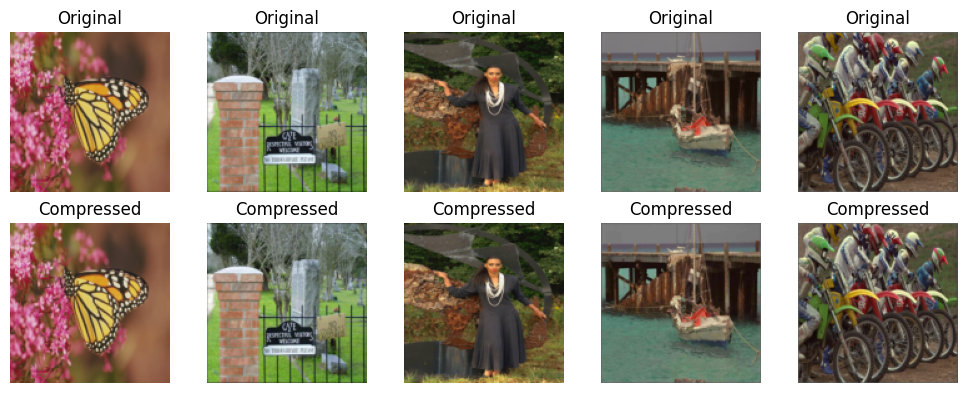

In [56]:
def visualize_samples(transformed_images, num_samples=5):
    """
    Visualizes sample images from the dataset.

    Args:
    transformed_images (list): List of transformed images (original, compressed).
    num_samples (int): Number of samples to visualize.
    """
    num_samples = min(num_samples, len(transformed_images))

    sampled_indices = np.random.choice(len(transformed_images), num_samples, replace=False)

    plt.figure(figsize=(10, 4))
    for i, idx in enumerate(sampled_indices):
        original_image, compressed_image = transformed_images[idx]
        original_image_np = original_image.numpy().transpose((1, 2, 0))
        compressed_image_np = compressed_image.numpy().transpose((1, 2, 0))
        
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(original_image_np)
        plt.title('Original')
        plt.axis('off')
        
        plt.subplot(2, num_samples, i + 1 + num_samples)
        plt.imshow(compressed_image_np)
        plt.title('Compressed')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

print("Visualizing sample images:")
visualize_samples(transformed_images, num_samples=5)

In [57]:
class EnhancedAutoencoder(nn.Module):
    def __init__(self):
        super(EnhancedAutoencoder, self).__init__()
        
        # Encoder: Convolutional layers with batch normalization
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),  # (B, 64, H/2, W/2)
            nn.BatchNorm2d(64),
            nn.ReLU(),  
            
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # (B, 128, H/4, W/4)
            nn.BatchNorm2d(128),
            nn.ReLU(),  
            
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # (B, 256, H/8, W/8)
            nn.BatchNorm2d(256),
            nn.ReLU(),  
            
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),  # (B, 512, H/16, W/16)
            nn.BatchNorm2d(512),
            nn.ReLU()  
        )
        
        # Decoder: Transpose convolutions to upsample and reconstruct
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),  # (B, 256, H/8, W/8)
            nn.BatchNorm2d(256),
            nn.ReLU(),  
            
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # (B, 128, H/4, W/4)
            nn.BatchNorm2d(128),
            nn.ReLU(),  
            
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # (B, 64, H/2, W/2)
            nn.BatchNorm2d(64),
            nn.ReLU(),  
            
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  # (B, 3, H, W)
            nn.Sigmoid()  
        )

        self.skip_connection1 = nn.Conv2d(128, 256, kernel_size=1)  
        self.skip_connection2 = nn.Conv2d(64, 128, kernel_size=1)   

    def forward(self, x):
        x1 = self.encoder[0:3](x)  
        x2 = self.encoder[3:6](x1)  
        x3 = self.encoder[6:](x2)  
        
        d3 = self.decoder[0:3](x3) 
        
        x2_resized = F.interpolate(x2, size=d3.shape[2:], mode='nearest')
        d3 = d3 + self.skip_connection1(x2_resized)  
        
        d2 = self.decoder[3:6](d3)  
        
        x1_resized = F.interpolate(x1, size=d2.shape[2:], mode='nearest')
        d2 = d2 + self.skip_connection2(x1_resized)  
        
        d1 = self.decoder[6:](d2)  
        
        return d1


In [58]:
def train_autoencoder(model, train_loader, val_loader, optimizer, criterion, num_epochs=100, lr_scheduler=None):
    """
    Trains the autoencoder model.

    Args:
    model (nn.Module): The autoencoder model to train.
    train_loader (DataLoader): DataLoader for training data.
    val_loader (DataLoader): DataLoader for validation data.
    optimizer (Optimizer): Optimizer to use for training.
    criterion (Loss): Loss function to minimize.
    num_epochs (int): Number of epochs for training.
    lr_scheduler (Scheduler): Learning rate scheduler.

    Returns:
    model: Trained autoencoder model.
    """
    train_losses = []
    val_losses = []

    # Early stopping initialization
    best_val_loss = float('inf')
    patience = 5  # Stop if validation loss doesn't improve after 5 epochs
    no_improvement_counter = 0

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0.0

        for batch_data in train_loader:
            original_images, compressed_images = batch_data
            original_images, compressed_images = original_images.to(device), compressed_images.to(device)
            
            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(original_images)

            # Loss calculation
            loss = criterion(outputs, compressed_images)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item() * original_images.size(0)

        # Learning rate scheduler step
        if lr_scheduler:
            lr_scheduler.step()

        # Calculate training and validation loss
        avg_train_loss = total_train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)

        avg_val_loss = validate_autoencoder(model, val_loader, criterion)
        val_losses.append(avg_val_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.6f}, Validation Loss: {avg_val_loss:.6f}')

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            no_improvement_counter = 0
        else:
            no_improvement_counter += 1

        if no_improvement_counter >= patience:
            print(f'Early stopping at epoch {epoch+1} due to no improvement in validation loss.')
            break

    # Plot the training and validation losses
    plot_losses(train_losses, val_losses)

    return model

In [59]:
def validate_autoencoder(model, val_loader, criterion):
    """
    Evaluates the autoencoder model on the validation set.

    Args:
    model (nn.Module): The trained model.
    val_loader (DataLoader): DataLoader for validation data.
    criterion (Loss): Loss function to calculate validation loss.

    Returns:
    float: Average validation loss.
    """
    model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_data in val_loader:
            original_images, compressed_images = batch_data
            original_images, compressed_images = original_images.to(device), compressed_images.to(device)

            # Forward pass
            outputs = model(original_images)

            # Loss calculation
            loss = criterion(outputs, compressed_images)
            total_val_loss += loss.item() * original_images.size(0)

    avg_val_loss = total_val_loss / len(val_loader.dataset)
    return avg_val_loss


In [60]:
def plot_losses(train_losses, val_losses):
    """
    Plots the training and validation loss curves.

    Args:
    train_losses (list): List of training losses.
    val_losses (list): List of validation losses.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()
    plt.show()

In [61]:
def evaluate_autoencoder(model, dataset, num_images=5):
    """
    Evaluates the autoencoder's performance using PSNR and SSIM metrics.

    Args:
    model (nn.Module): Trained autoencoder model.
    dataset (list): List of images to evaluate.
    num_images (int): Number of images to evaluate.

    Returns:
    float: Average PSNR value.
    float: Average SSIM value.
    """
    model.eval()
    psnr_values = []
    ssim_values = []
    num_images = min(num_images, len(dataset))  # Adjust number of images if too large
    selected_indices = np.random.choice(len(dataset), num_images, replace=False)

    with torch.no_grad():
        for idx in selected_indices:
            original_image, compressed_image = dataset[idx]
            original_image_input = original_image.to(device).unsqueeze(0)
            output = model(original_image_input).cpu().squeeze(0).numpy()

            original_image_np = original_image.numpy().transpose((1, 2, 0))
            compressed_image_np = compressed_image.numpy().transpose((1, 2, 0))
            output_np = output.transpose((1, 2, 0))

            # Clipping values to [0,1] range
            output_clipped = np.clip(output_np, 0, 1)
            compressed_clipped = np.clip(compressed_image_np, 0, 1)

            # Debugging: Print image shapes
            print(f"Image {idx} shapes:")
            print(f"  Original: {original_image_np.shape}")
            print(f"  Compressed: {compressed_image_np.shape}")
            print(f"  Output: {output_np.shape}")

            # Assertions to ensure image sizes
            assert original_image_np.shape[0] >= 7 and original_image_np.shape[1] >= 7, \
                f"Original image {idx} is smaller than 7x7."

            assert output_np.shape[0] >= 7 and output_np.shape[1] >= 7, \
                f"Output image {idx} is smaller than 7x7."

            # Compute PSNR and SSIM
            psnr_value = psnr(compressed_clipped, output_clipped, data_range=1)
            ssim_value = ssim(
                compressed_clipped, 
                output_clipped, 
                channel_axis=2, 
                data_range=1
                # Optionally, adjust win_size if necessary
                # win_size=5
            )

            psnr_values.append(psnr_value)
            ssim_values.append(ssim_value)

    avg_psnr = np.mean(psnr_values)
    avg_ssim = np.mean(ssim_values)

    print(f'Average PSNR: {avg_psnr:.4f}, Average SSIM: {avg_ssim:.4f}')
    
    return avg_psnr, avg_ssim


Epoch [1/100], Train Loss: 0.036619, Validation Loss: 0.044105
Epoch [2/100], Train Loss: 0.010961, Validation Loss: 0.030946
Epoch [3/100], Train Loss: 0.008293, Validation Loss: 0.019030
Epoch [4/100], Train Loss: 0.007441, Validation Loss: 0.013505
Epoch [5/100], Train Loss: 0.006190, Validation Loss: 0.010302
Epoch [6/100], Train Loss: 0.004929, Validation Loss: 0.007228
Epoch [7/100], Train Loss: 0.004635, Validation Loss: 0.005619
Epoch [8/100], Train Loss: 0.004278, Validation Loss: 0.004356
Epoch [9/100], Train Loss: 0.003823, Validation Loss: 0.003816
Epoch [10/100], Train Loss: 0.003596, Validation Loss: 0.003806
Epoch [11/100], Train Loss: 0.003553, Validation Loss: 0.003222
Epoch [12/100], Train Loss: 0.003533, Validation Loss: 0.003016
Epoch [13/100], Train Loss: 0.003397, Validation Loss: 0.002970
Epoch [14/100], Train Loss: 0.003618, Validation Loss: 0.002936
Epoch [15/100], Train Loss: 0.003721, Validation Loss: 0.002948
Epoch [16/100], Train Loss: 0.003321, Validation 

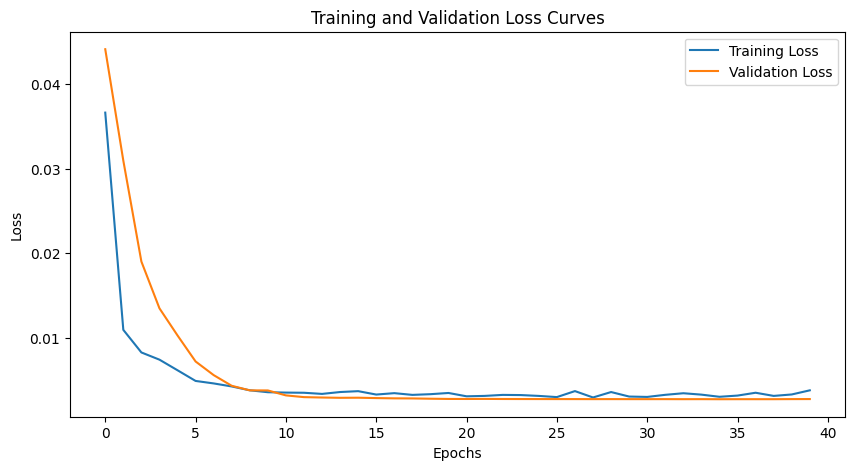

Image 49 shapes:
  Original: (128, 128, 3)
  Compressed: (128, 128, 3)
  Output: (128, 128, 3)
Image 0 shapes:
  Original: (128, 128, 3)
  Compressed: (128, 128, 3)
  Output: (128, 128, 3)
Image 27 shapes:
  Original: (128, 128, 3)
  Compressed: (128, 128, 3)
  Output: (128, 128, 3)
Image 24 shapes:
  Original: (128, 128, 3)
  Compressed: (128, 128, 3)
  Output: (128, 128, 3)
Image 10 shapes:
  Original: (128, 128, 3)
  Compressed: (128, 128, 3)
  Output: (128, 128, 3)
Average PSNR: 27.2027, Average SSIM: 0.8066
Final Model Performance - Average PSNR: 27.2027, Average SSIM: 0.8066


In [62]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_size = int(0.8 * len(transformed_images))
val_size = len(transformed_images) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(transformed_images, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

model = EnhancedAutoencoder().to(device)


optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


trained_model = train_autoencoder(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=100,
    lr_scheduler=lr_scheduler
)


avg_psnr, avg_ssim = evaluate_autoencoder(trained_model, val_dataset, num_images=5)

print(f"Final Model Performance - Average PSNR: {avg_psnr:.4f}, Average SSIM: {avg_ssim:.4f}")


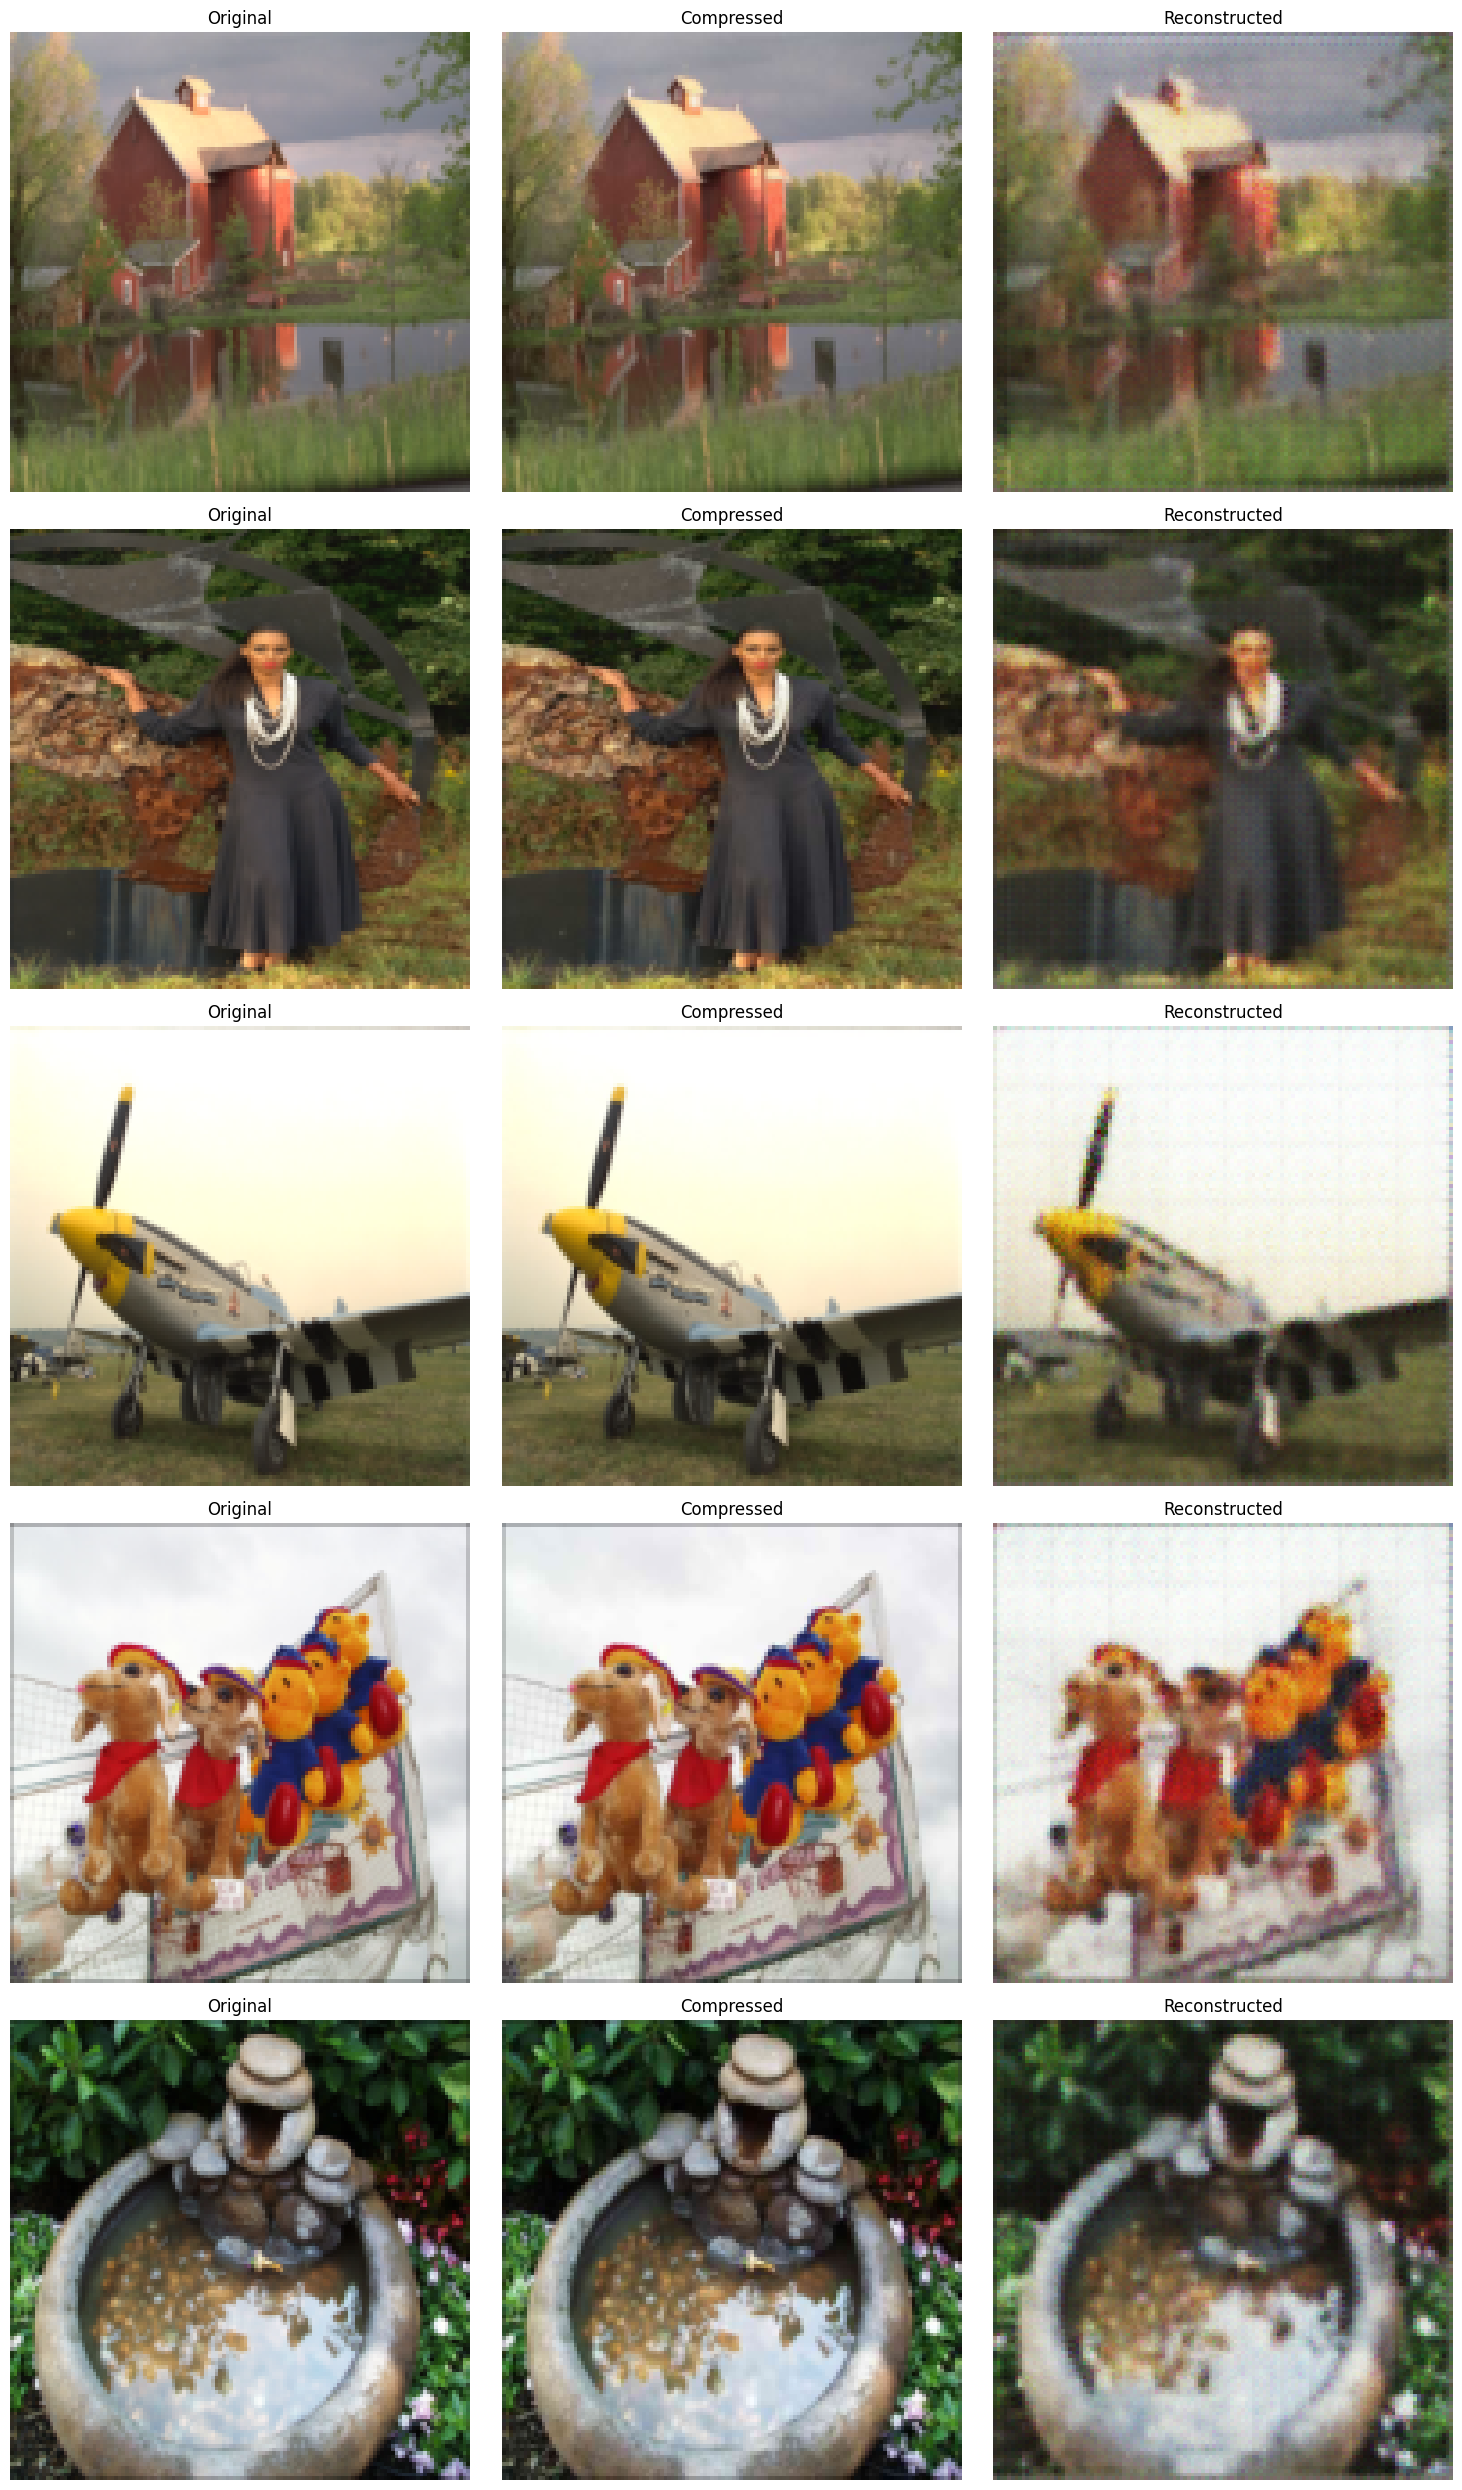

In [63]:
def visualize_reconstructions(model, dataset, num_images=5):
    model.eval()
    selected_indices = np.random.choice(len(dataset), num_images, replace=False)
    
    plt.figure(figsize=(15, num_images * 5))
    
    with torch.no_grad():
        for i, idx in enumerate(selected_indices):
            original, _ = dataset[idx]
            original_input = original.to(device).unsqueeze(0)
            output = model(original_input).cpu().squeeze(0).numpy().transpose((1, 2, 0))
            output_clipped = np.clip(output, 0, 1)
            
            # Original Image
            plt.subplot(num_images, 3, 3*i + 1)
            plt.imshow(original.numpy().transpose((1, 2, 0)))
            plt.title('Original')
            plt.axis('off')
            
            # Compressed Image
            compressed = dataset[idx][1].numpy().transpose((1, 2, 0))
            plt.subplot(num_images, 3, 3*i + 2)
            plt.imshow(np.clip(compressed, 0, 1))
            plt.title('Compressed')
            plt.axis('off')
            
            # Reconstructed Image
            plt.subplot(num_images, 3, 3*i + 3)
            plt.imshow(output_clipped)
            plt.title('Reconstructed')
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_reconstructions(trained_model, val_dataset, num_images=5)
